# $^{87}\mathrm{Rb}$ one photon

We import the functions of FAST and other useful stuff.

In [1]:
from fast.all import *
%matplotlib inline
from matplotlib import pyplot
from fast.config import parallel, use_netcdf
from scipy.optimize import curve_fit
from numpy import array

In [2]:
path='./3-rb87_one_photon/'
name='suite'

We first specify the states that we will use.

In [3]:
isotope=87
e1=State(isotope,5,S,Integer(1)/2)
e3=State(isotope,5,P,Integer(3)/2)
fine_states=[e1,e3]
print fine_states

[87Rb 5S_1/2, 87Rb 5P_3/2]


We split these states into hyperfine substates.

In [4]:
hyperfine_states=split_fine_to_hyperfine(fine_states)
print hyperfine_states

[87Rb 5S_1/2^1, 87Rb 5S_1/2^2, 87Rb 5P_3/2^0, 87Rb 5P_3/2^1, 87Rb 5P_3/2^2, 87Rb 5P_3/2^3]


We divide these hypefine states into their magnetic substates.

In [5]:
magnetic_states=split_hyperfine_to_magnetic(hyperfine_states)

We define the total number of states.

In [6]:
Ne=len(magnetic_states)

We choose a frequency state (and therefore a time scale).

In [7]:
Omega=1e6

We calculate the matrices for all the given states.

In [8]:
omega,gamma,r=calculate_matrices(magnetic_states,Omega)

We plot the resonant frequencies $\omega_{ij}$.

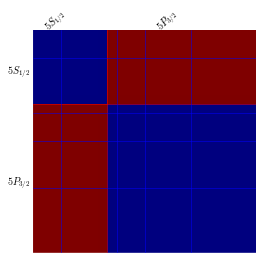

In [9]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
fancy_matrix_plot(ax,omega,magnetic_states,'_omega.png',take_abs=True,colorbar=True)

We plot the matrix of decays $\gamma_{ij}$.

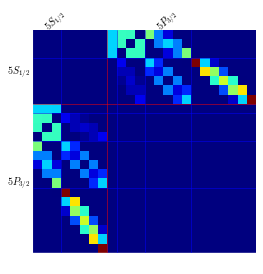

In [10]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
fancy_matrix_plot(ax,gamma,magnetic_states,path,name+'_gamma.png',take_abs=True,colorbar=True)

We plot the components of the position operator $\hat{\vec{r}}$.

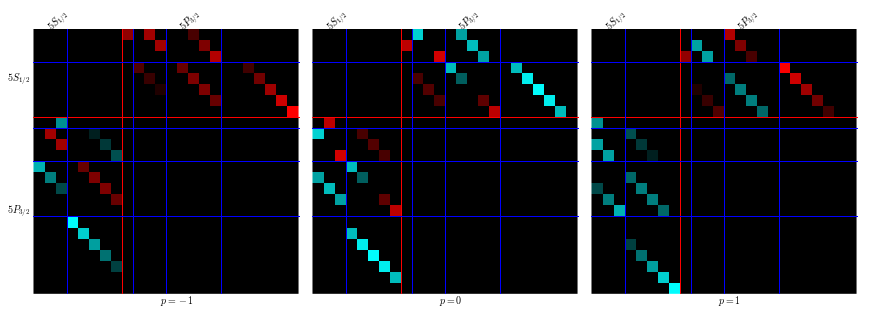

In [11]:
fancy_r_plot(r         ,magnetic_states,path,name+'_r.png', complex_matrix=True)

We define the laser we will use.

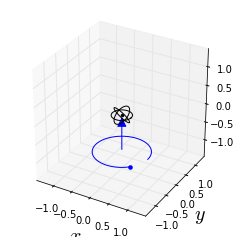

In [12]:
l1=PlaneWave(0,0,0,pi/8,symbolical=False)
lasers=[l1]
Nl=len(lasers)
fig = pyplot.figure(); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,lasers,path+name+'_lasers.png')

We specify the couplings of the lasers. In this case, all allowed transitions are coupled by laser 1.

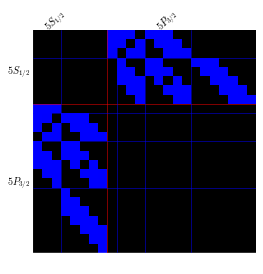

In [13]:
Lij=[]
for i in range(Ne):
    for j in range(i):
        if r[1][i][j]!=0 or r[0][i][j]!=0 or r[2][i][j]!=0:
            Lij+=[[j+1,i+1,[1]]]
            
Lij=formatLij(Lij,Ne)
fig=pyplot.figure(); ax=fig.add_subplot(111)
plot_Lij(ax,Lij,Nl,magnetic_states,path,name+'_Lij.png')

We draw a level diagram.

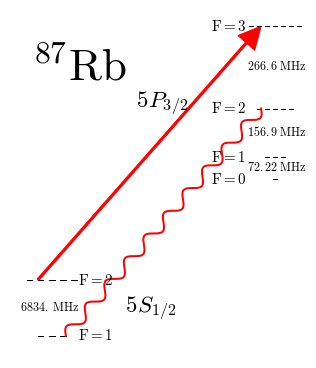

In [14]:
sc=2.0
fig=pyplot.figure(figsize=(sc*2.5,sc*3.0)); ax=fig.add_subplot(111,aspect="equal")
a=25; b=30
#ax.plot([0,a,a,0],[0,0,b,b],'w-',alpha=0.0)

xs=2.5; xp=22.5
p1 =[xs,  1.0]; w1 =5.0; h1 = 5.0
p2 =[xp, 15.0]; w2 =5.0; h2 = 2.0

a=False;a=True
h1=draw_multiplet(ax,e1 ,p1 ,h1 ,w1 ,fside='right',label_fontsize=23,label_separation=0.5,
												  fsize=15,deltanu_fontsize=12,text=e1._latex_()[16:],text_pos='right',magnetic_lines=a)
h2=draw_multiplet(ax,e3 ,p2 ,h2 ,w2 ,fside='left', label_fontsize=23,label_separation=0.75,
												  fsize=15,deltanu_fontsize=12,text=e3._latex_()[16:],text_pos='left',magnetic_lines=a)

excitation(ax,[h1[1][0]-0.25*5,h1[1][1]],[h2[3][0]-0.25*5,h2[3][1]], fc="red", ec="red",width=0.2, head_width=2, head_length=2)
decay(     ax,[h1[0][0]+0.25*5,h1[0][1]],[h2[2][0]-0.25*5,h2[2][1]], 0.5,10.0,color="red",linewidth=2.0)
ax.text(5,25,r"$^{"+str(isotope)+"}\mathrm{Rb}$",fontsize=45,verticalalignment="center",horizontalalignment="center")

pyplot.axis('off')
pyplot.savefig(path+name+'_levels.png',bbox_inches="tight")
pyplot.savefig(path+name+'_levels.pdf',bbox_inches="tight")

We calculate the amplitude of the electric field corresponding to saturation.

In [15]:
s0=1.0e1
E00=electric_field_amplitude_intensity(s0,Omega=Omega)
E0=[E00]
print E0

[14.254438462869667]


We calculate the transition frequencies of the (in MHz). The transitions $5 S_1/2 F=2 \rightarrow 5 P_3/2 F=1,2,3$ (the big F's).

In [16]:
nu0=Transition(hyperfine_states[3],hyperfine_states[1]).nu
t1=[(Transition(hyperfine_states[i+3],hyperfine_states[1]).nu -nu0)/Omega for i in range(3)]
print t1

[0.0, 156.940152625, 423.5917535625]


The transitions $5 S_1/2 F=1 \rightarrow 5 P_3/2 F=0,1,2$ (the small F's).

In [17]:
t2=[(Transition(hyperfine_states[i+2],hyperfine_states[0]).nu -nu0)/Omega for i in range(3)]
print t2

[6762.460809, 6834.682610875, 6991.6227635]


# Time evolution

We write the Fortran code of the experiment.

In [18]:
write_evolution(path,name+"_evolution",lasers,omega,gamma,r,Lij,verbose=0)

1.6529929637908936

We compile it.

In [19]:
compile_code(path,name+"_evolution",lapack=True,optimization_flag='',parallel=parallel)

0.7907679080963135

We begin with an initial state where all population is distributed equally between the $5S_{1/2}$ states.

In [20]:
rho0=[1/8.0 for i in range(7)]+[0.0 for j in range(24-8)]

We se what happens during 1 $\mu$s of evolution.

In [21]:
dt=1e-3; N_iter=1000
detuning_knob=[t1[2]*2*pi]

run_evolution(path,name+"_evolution",E0,detuning_knob, N_iter,dt,Ne,	rho0=rho0,use_netcdf=use_netcdf)

dat=read_result(path,name+"_evolution",N=Ne,use_netcdf=use_netcdf)
t=dat[0]
popfg1=dat[3-2:3]; pop1= [1-sum([dat[j+1][i] for j in range(23)]) for i in range(len(t))]
popfg1=[pop1]+popfg1
popfg2=dat[8-5:8]
popfmax=dat[24-7:24]

We plot what happens to the states $5S_{1/2}F=1$.

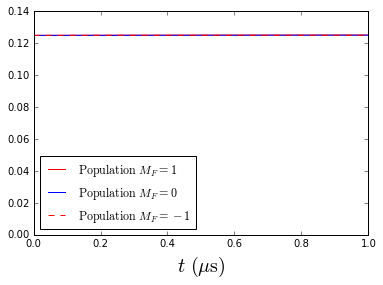

In [22]:
fig=pyplot.figure(); ax=fig.add_subplot(111)

ax.plot(t,popfg1[ 2],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfg1[ 1],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfg1[ 0],'--',color='r'		,label=r"$\mathrm{Population} \ M_F=-1$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mu\mathrm{s})$",fontsize=20)
ax.set_ylim([0,0.14])
pyplot.savefig(path+name+"_tshort_fg1.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tshort_fg1.pdf",bbox_inches="tight")


We plot what happens to states $5S_{1/2}F=2$.

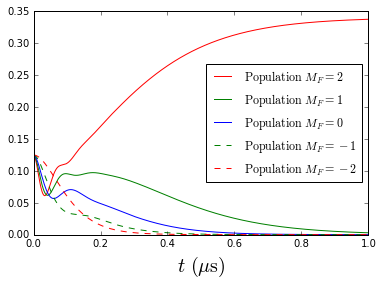

In [23]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
ax.plot(t,popfg2[ 4],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=2$")
ax.plot(t,popfg2[ 3],'-' ,color='g'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfg2[ 2],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfg2[ 1],'--' ,color='g'		,label=r"$\mathrm{Population} \ M_F=-1$")
ax.plot(t,popfg2[ 0],'--' ,color='r'		,label=r"$\mathrm{Population} \ M_F=-2$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mu\mathrm{s})$",fontsize=20)
ax.set_ylim([0,None])
pyplot.savefig(path+name+"_tshort_fg2.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tshort_fg2.pdf",bbox_inches="tight")

We plot what happens to the states $5P_{3/2}F=3$.

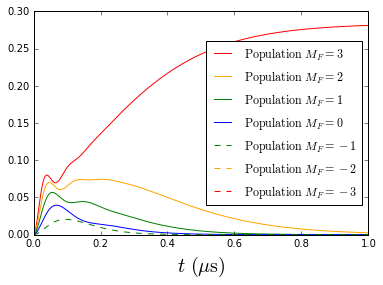

In [24]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
ax.plot(t,popfmax[ 6],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=3$")
ax.plot(t,popfmax[ 5],'-' ,color='orange'	,label=r"$\mathrm{Population} \ M_F=2$")
ax.plot(t,popfmax[ 4],'-' ,color='g'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfmax[ 3],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfmax[ 2],'--',color='g'		,label=r"$\mathrm{Population} \ M_F=-1$")
ax.plot(t,popfmax[ 1],'--',color='orange'	,label=r"$\mathrm{Population} \ M_F=-2$")
ax.plot(t,popfmax[ 0],'--',color='r'		,label=r"$\mathrm{Population} \ M_F=-3$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mu\mathrm{s})$",fontsize=20)
ax.set_ylim([0,None])
pyplot.savefig(path+name+"_tshort_fmax.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tshort_fmax.pdf",bbox_inches="tight")

We see what happens during 1 s of evolution.

In [25]:
dt=1.0e3; N_iter=1000
detuning_knob=[t1[2]*2*pi]

run_evolution(path,name+"_evolution",E0,detuning_knob, N_iter,dt,Ne,	rho0=rho0,use_netcdf=use_netcdf)

dat=read_result(path,name+"_evolution",N=Ne,use_netcdf=use_netcdf)
t=dat[0]
t=[ti/1e6 for ti in t]
popfg1=dat[3-2:3]; pop1= [1-sum([dat[j+1][i] for j in range(23)]) for i in range(len(t))]
popfg1=[pop1]+popfg1
popfg2=dat[8-5:8]
popfmax=dat[24-7:24]

We plot what happens to states $5S_{1/2}F=1$.

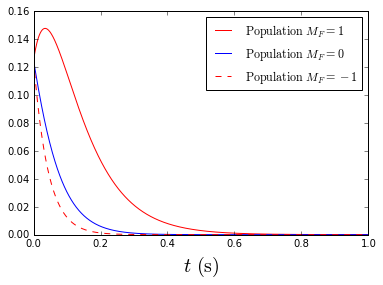

In [26]:
fig=pyplot.figure(); ax=fig.add_subplot(111)

ax.plot(t,popfg1[ 2],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfg1[ 1],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfg1[ 0],'--',color='r'		,label=r"$\mathrm{Population} \ M_F=-1$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mathrm{s})$",fontsize=20)
ax.set_ylim([0,None])
pyplot.savefig(path+name+"_tlong_fg1.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tlong_fg1.pdf",bbox_inches="tight")

We plot what happens to states $5S_{1/2}F=2$.

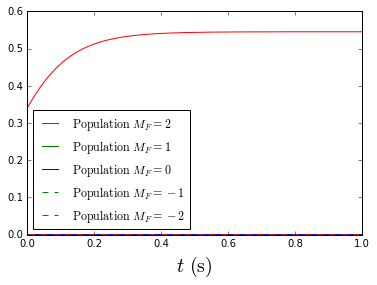

In [27]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
ax.plot(t,popfg2[ 4],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=2$")
ax.plot(t,popfg2[ 3],'-' ,color='g'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfg2[ 2],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfg2[ 1],'--' ,color='g'		,label=r"$\mathrm{Population} \ M_F=-1$")
ax.plot(t,popfg2[ 0],'--' ,color='r'		,label=r"$\mathrm{Population} \ M_F=-2$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mathrm{s})$",fontsize=20)
ax.set_ylim([0,None])
pyplot.savefig(path+name+"_tlong_fg2.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tlong_fg2.pdf",bbox_inches="tight")

We plot what happens to states $5P_{3/2}F=3$.

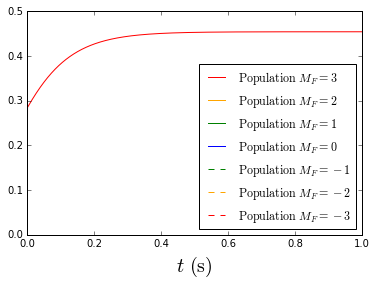

In [28]:
fig=pyplot.figure(); ax=fig.add_subplot(111)
ax.plot(t,popfmax[ 6],'-' ,color='r'		,label=r"$\mathrm{Population} \ M_F=3$")
ax.plot(t,popfmax[ 5],'-' ,color='orange'	,label=r"$\mathrm{Population} \ M_F=2$")
ax.plot(t,popfmax[ 4],'-' ,color='g'		,label=r"$\mathrm{Population} \ M_F=1$")
ax.plot(t,popfmax[ 3],'-' ,color='b'		,label=r"$\mathrm{Population} \ M_F=0$")
ax.plot(t,popfmax[ 2],'--',color='g'		,label=r"$\mathrm{Population} \ M_F=-1$")
ax.plot(t,popfmax[ 1],'--',color='orange'	,label=r"$\mathrm{Population} \ M_F=-2$")
ax.plot(t,popfmax[ 0],'--',color='r'		,label=r"$\mathrm{Population} \ M_F=-3$")

ax.legend(loc=0)
ax.set_xlabel(r"$t\ (\mathrm{s})$",fontsize=20)
ax.set_ylim([0,None])
pyplot.savefig(path+name+"_tlong_fmax.png",bbox_inches="tight")
pyplot.savefig(path+name+"_tlong_fmax.pdf",bbox_inches="tight")

## Steady State

We write the Fortran code of the experiment.

In [29]:
2+2

4

In [30]:
write_stationary(path,name+"_steady",lasers,omega,gamma,r,Lij,verbose=0)

1.7198338508605957

We compile it.

In [31]:
compile_code(path,name+"_steady",lapack=True,parallel=parallel)

12.195791959762573

We now make a test of this stationary two-level state to make sure.

I/I0= 0.01 E0= 0.450764923094
I/I0= 0.016681005372 E0= 0.582185285422
I/I0= 0.0278255940221 E0= 0.751921210364
I/I0= 0.0464158883361 E0= 0.971143587363
I/I0= 0.0774263682681 E0= 1.25428017494
I/I0= 0.129154966501 E0= 1.61996513978
I/I0= 0.215443469003 E0= 2.09226543362
I/I0= 0.35938136638 E0= 2.70226471991
I/I0= 0.599484250319 E0= 3.49010909378
I/I0= 1.0 E0= 4.50764923094
I/I0= 1.6681005372 E0= 5.82185285422
I/I0= 2.78255940221 E0= 7.51921210364
I/I0= 4.64158883361 E0= 9.71143587363
I/I0= 7.74263682681 E0= 12.5428017494
I/I0= 12.9154966501 E0= 16.1996513978
I/I0= 21.5443469003 E0= 20.9226543362
I/I0= 35.938136638 E0= 27.0226471991
I/I0= 59.9484250319 E0= 34.9010909378
I/I0= 100.0 E0= 45.0764923094


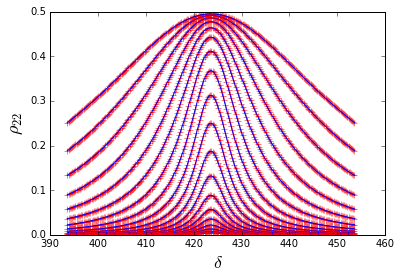

In [32]:
run_long_tests=1
if run_long_tests>=1:
	def model_lorentzian(n=1):
		s='lambda x,'
		for i in range(1,n+1): s+=' A'+str(i)+','
		for i in range(1,n+1): s+=' x0'+str(i)+','
		for i in range(1,n+1): s+=' gamma'+str(i)+','
		s=s[:-1]
		s+=' :'
		for i in range(1,n+1): s+=' A'+str(i)+'*gamma'+str(i)+'**2/(4*(x-x0'+str(i)+')**2+gamma'+str(i)+'**2) +'
		s=s[:-1]
		return eval(s)

	def fit_lorentzians(x,y,p0=None,n=1,return_p0=False):
		'''Fits a lorentzian curve using p0=[A1,A2,...,x1,x2,...,gamma1,gamma2,...] as an initial guess.
		It returns a curve with N_points.'''
		
		lorentzians=model_lorentzian(n)
		N=len(x)
		if return_p0:
			fit=p0;pcov=None
		else:
			fit,pcov = curve_fit(lorentzians,x,y,p0=p0)
		s=''.join([',fit['+str(i)+']' for i in range(3*n)])
		s='[lorentzians(xi'+s+') for xi in x]'
		fitted_curve=eval(s)
		
		for i in range(n):
			fit[-i-1]=abs(fit[-i-1])
		return fit,pcov,fitted_curve

	########################################################################
	Npow=19; pow_ini=-2.0; pow_end=2.0; pow_step=(pow_end-pow_ini)/(Npow-1)
	pows=[10**(pow_ini+i*pow_step) for i in range(Npow)]
	model_widths=[]; simple_widths=[]
	model_pops=[]; simple_pops=[]
	detuning_knob=[(t1[2]-30)*2*pi]
	frequency_end=(t1[2]+30)*2*pi
	#print 111
	N_delta=250
	for s0 in pows:
		
		E000=[electric_field_amplitude_intensity(s0,Omega=Omega)]
		
		run_stationary(path,name+"_steady",E000,detuning_knob,spectrum_of_laser=1,N_delta=N_delta, frequency_end=frequency_end,use_netcdf=use_netcdf)

		nu,pop0=read_result(path,name+"_steady",Ne,Ne,1,Ne,use_netcdf=use_netcdf)
		nu=[nui/2/pi for nui in nu]
		
		fit,pcov,fitted_curve=fit_lorentzians(nu,pop0,[pop0[N_delta/2],t1[2],1.04],n=1,return_p0=False)
		pyplot.plot(nu,pop0,'r+')
		pyplot.plot(nu,fitted_curve,'b-')
		Ai,x0i,gammai=fit
		
		model_widths+=[gammai]
		Gamma=6.065
		simple_widths+=[Gamma*sqrt(1+2*s0)]
		
		model_pops+=[Ai]
		simple_pops+=[2*s0/2/(1+2*s0)]
		
		print 'I/I0=',s0,'E0=',E000[0]

pyplot.xlabel(r"$\delta$",fontsize=18)
pyplot.ylabel(r"$\rho_{22}$",fontsize=18)
pyplot.savefig(path+name+"_1power.png",bbox_inches="tight")

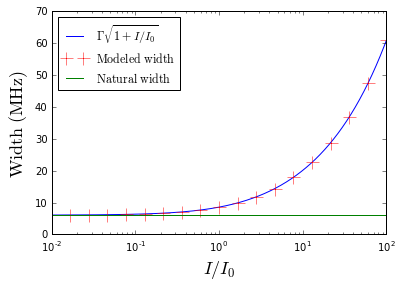

In [33]:
pyplot.close("all")
Npow=1000; pow_ini=-2.0; pow_end=2.0; pow_step=(pow_end-pow_ini)/(Npow-1)
pows2=[10**(pow_ini+i*pow_step) for i in range(Npow)]

#We plot widths
simple_widths =[6.065*sqrt(1+s0) for s0 in pows2]

pyplot.semilogx(pows2,simple_widths,'-b',basex=10,label=r'$\Gamma\sqrt{1+I/I_0}$')
pyplot.semilogx(pows,model_widths,'+r',basex=10,label=r'$\mathrm{Modeled \ width}$',markersize=13)
pyplot.plot(pows2,[6.065]*Npow,'g-',label=r'$\mathrm{Natural \ width}$')

pyplot.xlabel(r"$I/I_0$",fontsize=18)
pyplot.ylabel(r"$\mathrm{Width \ (MHz)}$",fontsize=18)

pyplot.ylim([0,None])
pyplot.legend(loc=0)

pyplot.savefig(path+name+'_2power.png',bbox_inches='tight')

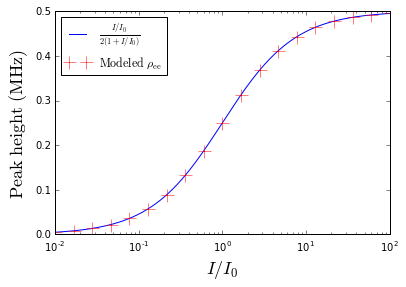

In [34]:
pyplot.close()
#We plot amplitudes
simple_pops =[ s0/2/(1+ s0) for s0 in pows2]
pyplot.semilogx(pows2,simple_pops,'-b',basex=10,label=r'$\frac{I/I_0}{2(1+I/I_0)}$')
pyplot.semilogx(pows,model_pops,'+r',basex=10,label=r'$\mathrm{Modeled \ \rho_{ee}}$',markersize=13)
pyplot.xlabel(r"$I/I_0$",fontsize=18)
pyplot.ylabel(r"$\mathrm{Peak\ height \ (MHz)}$",fontsize=18)


pyplot.ylim([0,None])
pyplot.legend(loc=0)

pyplot.ylim([0,None])
pyplot.legend(loc=0)

pyplot.savefig(path+name+'_3power.png',bbox_inches='tight')

In [35]:
pyplot.close()